# **Árvore de Regressão e Random Forest**

* Parte 1: Entendimento e divisão do dataset
* Parte 2: Aplicação do algoritmo DecisionTreeRegressor
* Parte 3: Avaliação de desempenho
* Parte 4: Aplicação do algoritmo RandomForest
* Parte 5: Avaliação de desempenho

# <font color=yellow>**Parte 1**: Entendimento e divisão do dataset

Definição das variáveis
- so2 IAG
- so2_1 estação
- so2_2 estação
- so2_3 estação
- so2_4 estação
- so2_we (working electord)
- so2_ae (auxiliary electrodo)
- best_so

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Leitura da base de dados
df = pd.read_csv('Best-SO2-data-2025.csv')
df.head()

,Time,SO2
0,2025-02-22 15:18:16,682 ppb
1,2025-02-22 15:19:29,682 ppb
2,2025-02-22 15:20:42,682 ppb
3,2025-02-22 15:24:06,682 ppb
4,2025-02-22 15:25:12,682 ppb


In [4]:
aqm = pd.read_csv('envcity_aqm_df.csv')
#print(aqm.shape)
#print(aqm.describe())
aqm.head()

,time,e1_anem,e1_anem_volt,e1_co,e1_co_2,e1_co_3,e1_co_4,e1_co_ae,e1_co_we,e1_location,...,iag_pm25,iag_pmcoarse,iag_pressure,iag_rainfalltotal,iag_sigma,iag_so2,iag_solarradiation,iag_wd,iag_ws,pin_umid
0,2023-02-15 13:41:00,12.036327,NaN,-1315.716919,459.329041,465.226715,598.345581,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-02-15 13:42:00,11.174897,NaN,-1575.367554,385.721252,395.833496,624.081055,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-02-15 13:43:00,11.703624,NaN,-3228.860352,-520.005371,-492.953430,117.647057,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-02-15 13:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-02-15 13:45:00,11.888990,NaN,-1663.602783,315.461090,325.980530,563.419250,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
import pandas as pd

# 1. Carregar o CSV (caso ainda não esteja carregado)
# aqm = pd.read_csv("envcity_aqm_df.csv")  # já carregado, então vamos seguir direto

# 2. Encontrar o índice da primeira linha com valor em 'iag_so2'
primeiro_index = aqm[aqm['iag_so2'].notna()].index[0]

# 3. Criar o DataFrame a partir dessa linha até o fim
df_iag = aqm.loc[primeiro_index:].copy()

# 4. Remover as colunas que continuam 100% vazias nesse trecho
df_iag_limpando = df_iag.loc[:, df_iag.notna().any(axis=0)]

# 5. Mostrar resultado
print(f"Índice inicial: {primeiro_index}")
print(f"Número de colunas restantes: {df_iag_limpando.shape[1]}")
print(df_iag_limpando.head())


Índice inicial: 40939
Número de colunas restantes: 110
                      time   e1_anem  e1_anem_volt       e1_co     e1_co_2  \
40939  2023-03-16 00:00:00  8.239560           NaN  374.827820  247.304489   
40940  2023-03-16 00:01:00       NaN           NaN         NaN         NaN   
40941  2023-03-16 00:02:00       NaN        0.4905         NaN         NaN   
40942  2023-03-16 00:03:00       NaN           NaN         NaN         NaN   
40943  2023-03-16 00:04:00  8.240365           NaN  383.092285  240.663635   

          e1_co_3     e1_co_4  e1_co_ae  e1_co_we    e1_no2  ...  iag_pm25  \
40939  173.381546 -796.487610       NaN       NaN -0.161290  ...     4.077   
40940         NaN         NaN       NaN       NaN       NaN  ...     4.055   
40941         NaN         NaN     0.309   0.40575       NaN  ...     4.843   
40942         NaN         NaN       NaN       NaN       NaN  ...     5.068   
40943  166.150131 -811.466919       NaN       NaN -0.040322  ...     5.046   

       

In [ ]:
df['Time'] = pd.to_datetime(df['Time'])
df['hour'] = df['Time'].dt.hour
df['minute'] = df['Time'].dt.minute
df['day'] = df['Time'].dt.day
df['month'] = df['Time'].dt.month

# Converter SO2 para numérico
df['SO2'] = df['SO2'].str.replace(' ppb', '').astype(float)



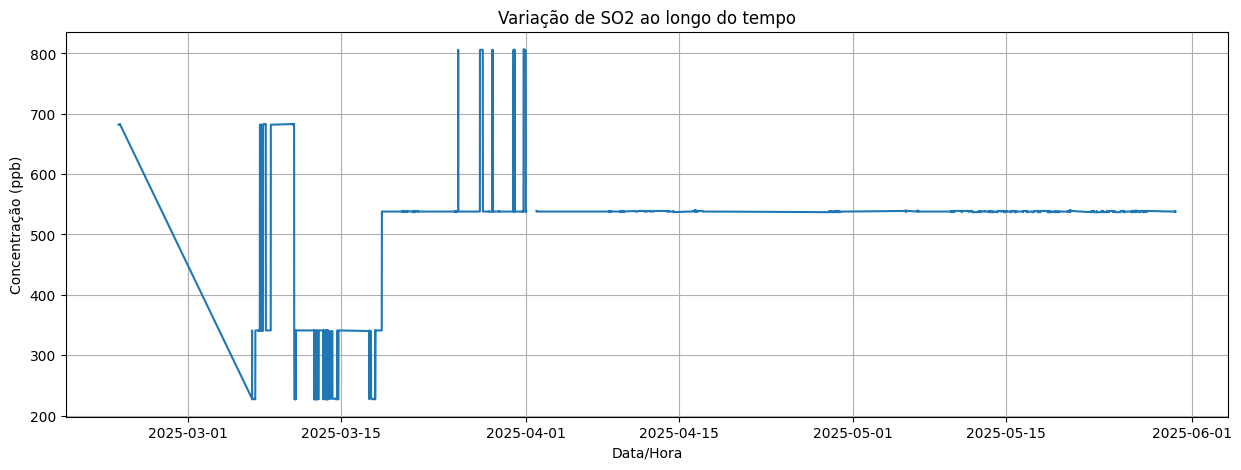

In [20]:
plt.figure(figsize=(15,5))
plt.plot(df['Time'], df['SO2'])
plt.title('Variação de SO2 ao longo do tempo')
plt.xlabel('Data/Hora')
plt.ylabel('Concentração (ppb)')
plt.grid()
plt.show()

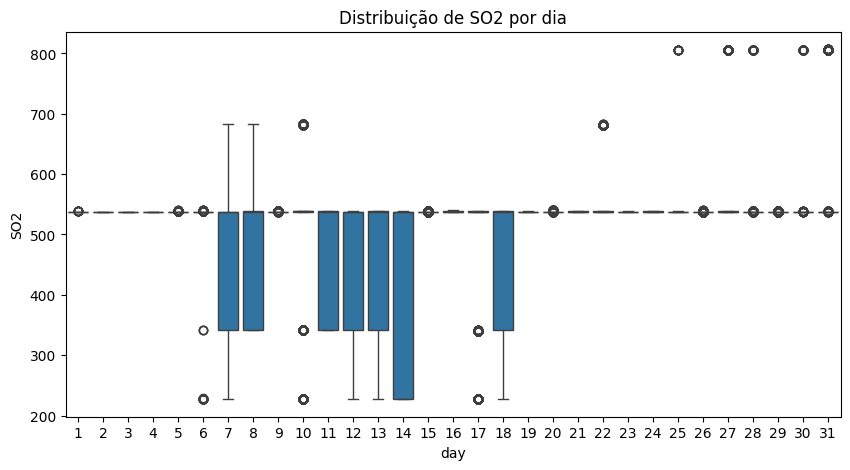

In [21]:
#Boxplot 

plt.figure(figsize=(10,5))
sns.boxplot(x='day', y='SO2', data=df)
plt.title('Distribuição de SO2 por dia')
plt.show()

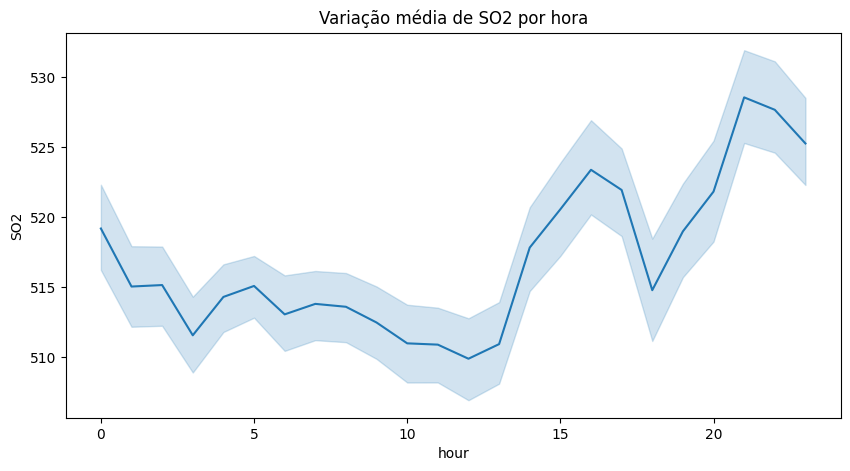

In [ ]:
#analise do horario

plt.figure(figsize=(10,5))
sns.lineplot(x='hour', y='SO2', data=df)
plt.title('Variação média de SO2 por hora')
plt.show()

In [23]:
#compara estatitisticas descritivas entre os dias

df.groupby('day')['SO2'].describe()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
1,65.0,538.215385,0.414288,538.0,538.0,538.0,538.0,539.0
2,1122.0,538.000000,0.000000,538.0,538.0,538.0,538.0,538.0
3,1140.0,538.000000,0.000000,538.0,538.0,538.0,538.0,538.0
4,1141.0,538.000000,0.000000,538.0,538.0,538.0,538.0,538.0
5,1399.0,538.091494,0.295760,538.0,538.0,538.0,538.0,540.0
6,1359.0,528.760118,52.590505,227.0,538.0,538.0,538.0,540.0
7,2250.0,465.031556,135.132474,227.0,341.0,538.0,538.0,683.0
8,1384.0,495.882948,136.883458,341.0,341.0,538.0,539.0,683.0
9,1273.0,538.128044,0.421633,537.0,538.0,538.0,538.0,539.0


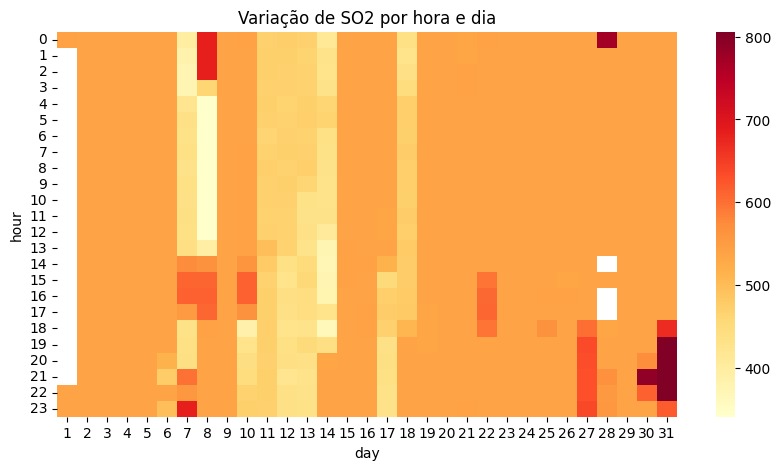

In [24]:
pivot = df.pivot_table(values='SO2', index='hour', columns='day')
plt.figure(figsize=(10,5))
sns.heatmap(pivot, cmap='YlOrRd')
plt.title('Variação de SO2 por hora e dia')
plt.show()

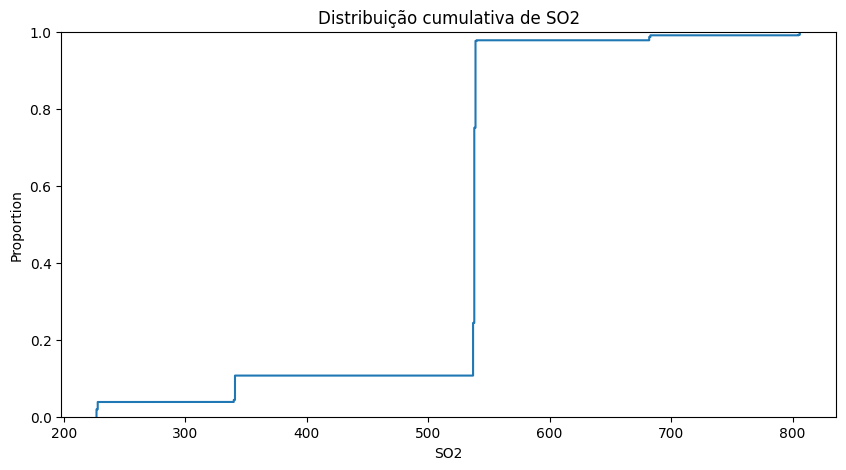

In [25]:
plt.figure(figsize=(10,5))
sns.ecdfplot(data=df, x='SO2')
plt.title('Distribuição cumulativa de SO2')
plt.show()

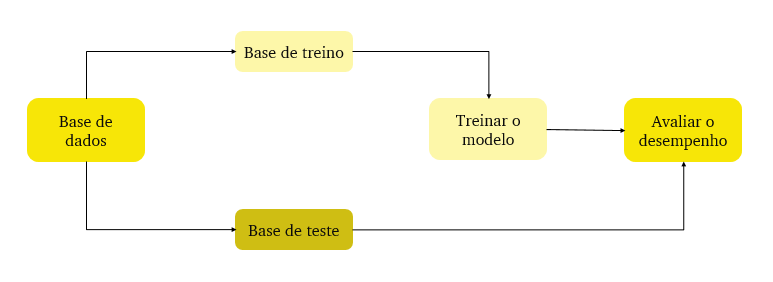

In [ ]:
from sklearn.model_selection import train_test_split

# Dividindo a base de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

# <font color=yellow>**Parte 2**: Aplicação do algoritmo DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Criando a classe DecisionTreeRegressor()
regressor = DecisionTreeRegressor()

# Ajustando o algoritmo a base de dados
regressor.fit(X_train, y_train)

# Prevendo os resultados
y_pred = regressor.predict(X_test)

In [ ]:
# Comparando os valores reais com os valores previstos
df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df.head()

In [ ]:
import plotly.express as px

# Plotando gráfico
fig = px.line(df, y=['Real Values', 'Predicted Values'])
fig.show()

# <font color=yellow>**Parte 3**: Avaliação de desempenho

Principais métricas para avaliação de desempenho de um modelo de regressão:

* **R² (Coeficiente de Determinação)** - varia de 0 a 1 e representa a proporção da variabilidade na variável dependente que pode ser explicada pelo modelo.
* **MAE (Erro Absoluto Médio)** - avalia a precisão de um modelo prever os dados já observados, sendo a média das diferenças absolutas entre as previsões do modelo e os valores reais.
* **MSE (Erro Quadrático Médio)** - também avalia a precisão do modelo, sendo calculado a partir da média das diferenças ao quadrado entre os valores previstos e os valores reais, penalizando mais erros maiores.
* **RMSE (Raiz do Erro Quadrático Médio)** - é a raiz quadrada do MSE, tornando-se assim uma métrica mais fácil de ser interpretar, já que fica na mesma unidade que o dado original.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculando R²
r2 = r2_score(y_test, y_pred)

# Calculando MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculando MSE
mse = mean_squared_error(y_test, y_pred)

# Calculando RMSE
rmse = np.sqrt(mse)

print('R2:', r2)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

Um dos principais problemas do algoritmo da Árvore de Decisão é o **OVERFITTING**: 
- Quando na base de treino o modelo tem um bom desempenho, mas na base de teste tem um desempenho ruim
- O modelo se ajustou de forma tão precisa aos dados de treinamento que aprende o ruído aleatório dos dados, mas não generaliza bem para novos dados.



# <font color=yellow>**Parte 4**: Aplicação do algoritmo RandomForest

Parâmetros:
- n_estimators: número de árvores na floresta
- max_features: número máximo de recursos considerados para dividir um nó
- max_depth: número máximo de níveis em cada árvore de decisão
- random_state: semente usada para gerar números aleatórios durante a execução do modelo

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Criando a classe RandomForestRegressor()
rf_regressor = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18)

# Ajustando o algoritmo a base de dados
rf_regressor.fit(X_train, y_train)

# Prevendo os resultados
y_pred = rf_regressor.predict(X_test)

In [ ]:
# Comparando os valores reais com os valores previstos
df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df.head()

In [ ]:
# Plotando gráfico
fig = px.line(df, y=['Real Values', 'Predicted Values'])
fig.show()

# <font color=yellow>**Parte 5**: Avaliação de desempenho

In [ ]:
# Calculando R²
r2 = r2_score(y_test, y_pred)

# Calculando MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculando MSE
mse = mean_squared_error(y_test, y_pred)

# Calculando RMSE
rmse = np.sqrt(mse)

print('R2:', r2)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)